In [3]:
import umap.umap_
import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numba
import random
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

###   t-SNE, UMAP and LargeVis

In this and the next notebook we will use manifold learning for data visualization of large data sets (with high dimensionality). In addition to t-SNE, two relatively new methods will be used that are more efficient on large data sets.


- UMAP (Uniform Manifold Approximation and Projection) - Install this Python package: https://umap-learn.readthedocs.io/en/latest/index.html. UMAP package is compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. UMAP can work as a drop in replacement for t-SNE and other dimension reduction classes from scikit-learn


- LargeVis (Visualizing Large-scale and High-dimensional Data) - Many techniques (like t-SNE, UMAP and LargeVis) first compute a similarity structure of the data points and then project them into a low-dimensional space with the structure preserved. These two steps suffer from considerable computational costs Comparing to tSNE, LargeVis significantly reduces the computational cost of the graph construction step and employs a principled probabilistic model for the visualization step, the objective of which can be effectively optimized through asynchronous stochastic gradient descent with a linear time complexity. Download this algorithm repository and follow the installation instructions. https://github.com/lferry007/LargeVis




To get data we use the sklearn.datasets.fetch_openml method, which as the name requires, Fetch dataset from openml by name or dataset id. We will use MNIST and Fashion-MNIST(Zalando's article images). Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. Instead of numbers it contains thumbnails of clothes images.

In [4]:
mnist = sklearn.datasets.fetch_openml('mnist_784')
fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')

In [5]:
X_mnist_all = mnist.data
X_fmnist_all = fmnist.data
y_mnist_all = mnist.target
y_fmnist_all = fmnist.target

In [20]:
X_mnist, x_mtest, y_mnist, y_mtest = train_test_split(mnist.data, mnist['target'], test_size=0.8, random_state=80)
X_fmnist, x_ftest, y_fmnist, y_ftest = train_test_split(fmnist.data, fmnist['target'], test_size=0.8, random_state=80)


Below are drawings of some samples from mnist and fmnist data sets

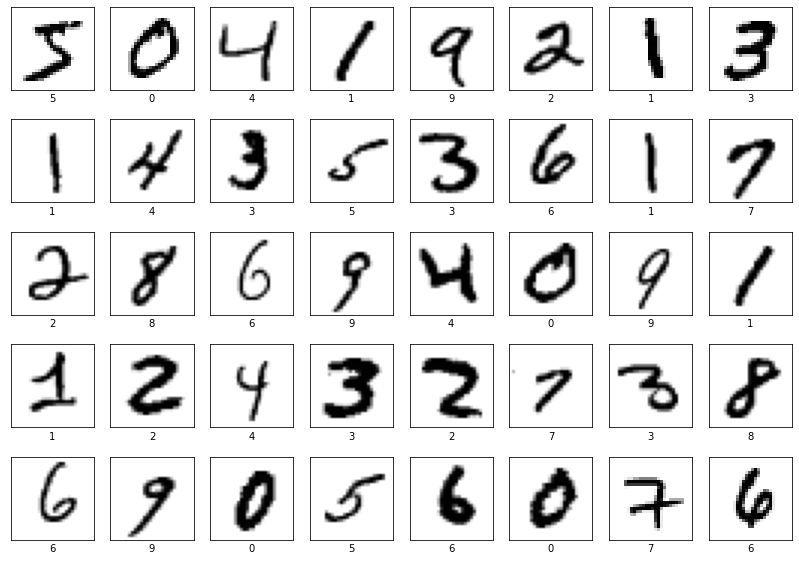

In [87]:
mnist_names = [i for i in range(10)]
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(mnist_names[int(mnist.target[i])])
plt.show()

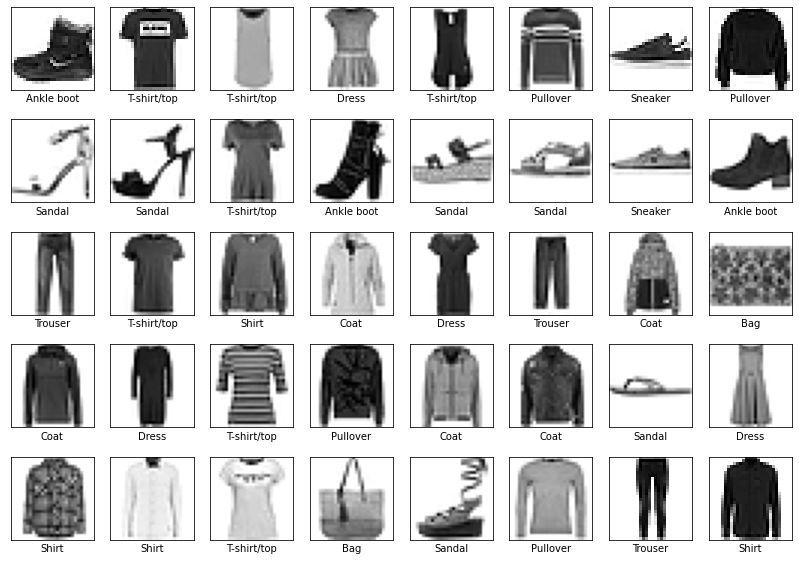

In [88]:
fmnist_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
plt.figure(figsize=(14,10))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist.data[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(fmnist_names[int(fmnist.target[i])])
plt.show()

#### Use t-SNE, UMAP and LargeVis to project mnist and fmnist data sets into a 2-dimensional space. For LargeVis, you need to create a function that saves the data to the required by LargeVis txt file format, and a function that loads the resulting file. Draw charts for all visualizations.

# t-SNE

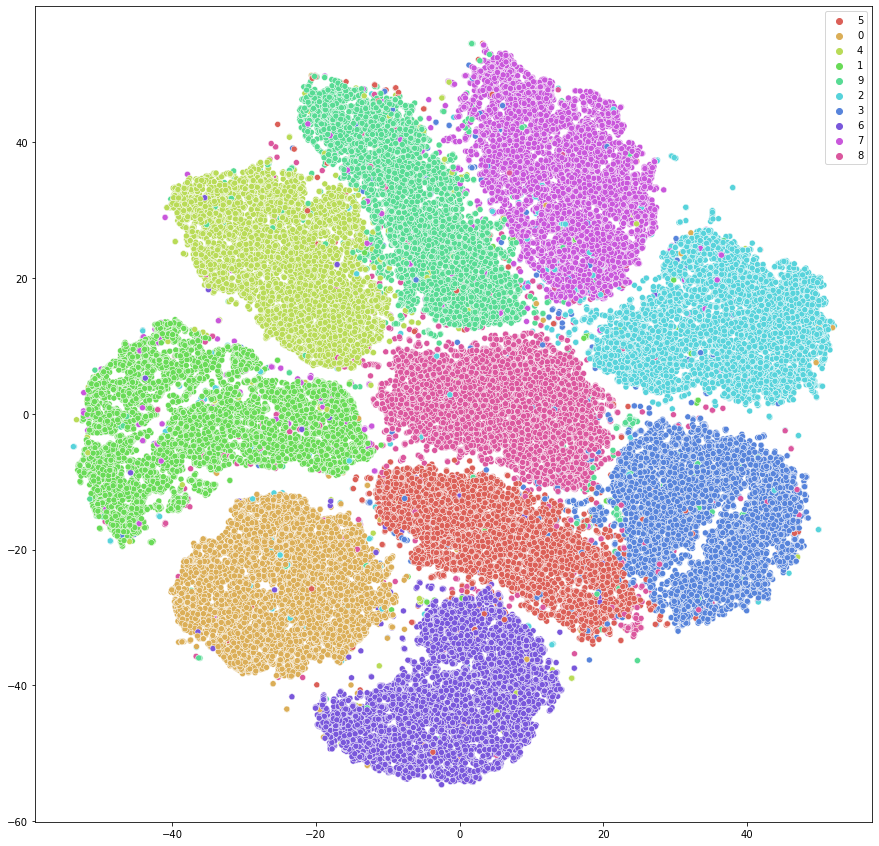

In [89]:
model = TSNE(n_components = 2, random_state=0)
tsne_mnist = model.fit_transform(X_mnist_all)

fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = tsne_mnist[:,0], y = tsne_mnist[:,1], hue =y_mnist_all, 
                palette = sns.hls_palette(10), legend = 'full');

Metoda t-SNE bardzo dobrze radzi sobie z wizualizacją zbioru MNIST. Mimo zauważalnych pomyłek, widoczne są skupiska klas (grupowane lokalnie). Wadą tej metody jest natomiast fakt, że dane przetwarzają się przez bardzo długi czas.


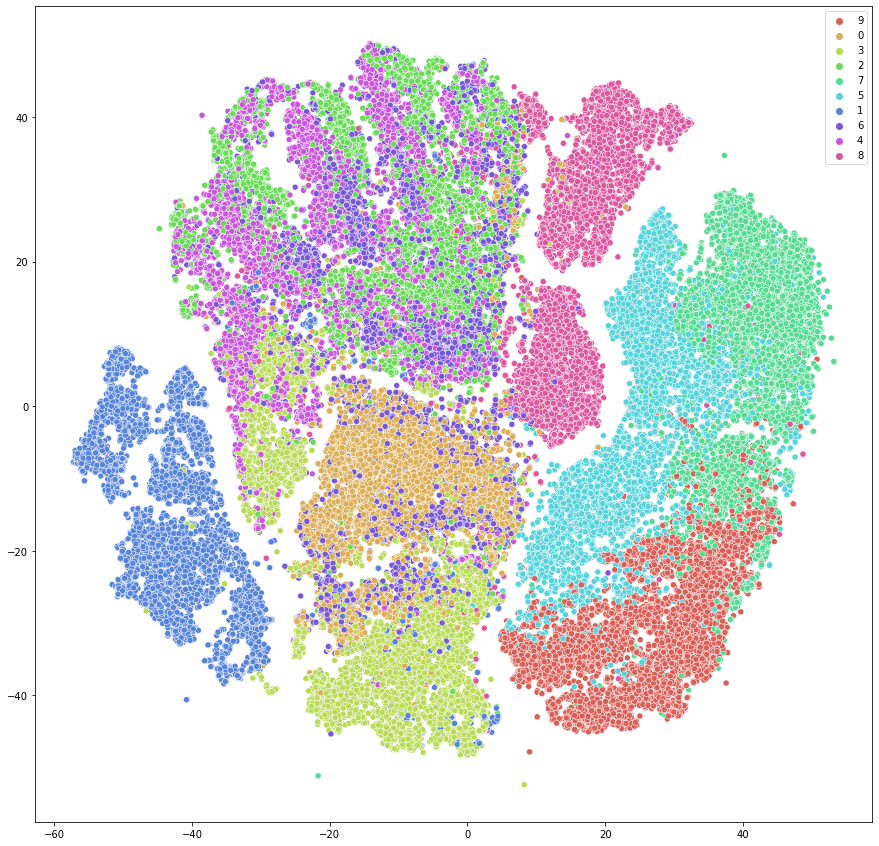

In [91]:
model = TSNE(n_components = 2, random_state=0)
tsne_fmnist = model.fit_transform(X_fmnist_all)

fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = tsne_fmnist[:,0], y = tsne_fmnist[:,1], hue =y_fmnist_all, 
                palette = sns.hls_palette(10), legend = 'full');

Wizualizacja zbioru FMNIST za pomocą metody t-SNE nie przyniosła oczekiwanych rezultatów. Widoczne są jedynie dwie odseparowane grupy.  

# UMAP

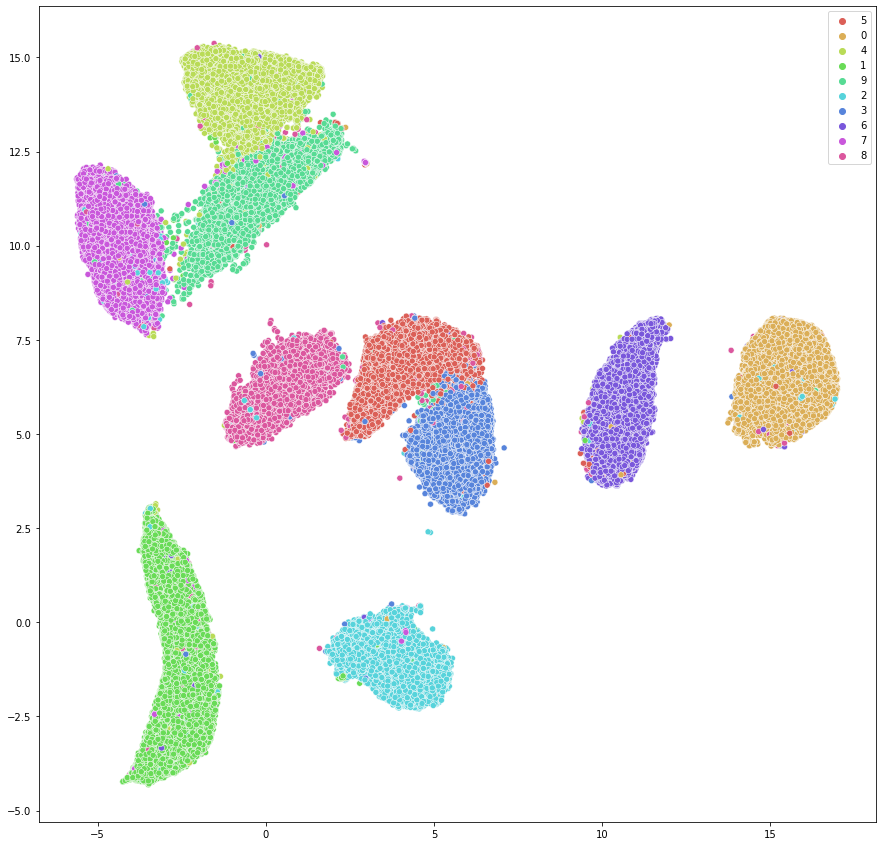

In [366]:
model = umap.UMAP(random_state=42)
umap_mnist = model.fit_transform(X_mnist_all)

fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = umap_mnist[:,0], y = umap_mnist[:,1], hue =y_mnist_all, 
                palette = sns.hls_palette(10), legend = 'full');

UMAP w przeciwieństwie do t-SNE grupuje etykiety w sposób globalny, co skutkuje widocznymi odległościami między klastrami. Wyjątkami są "podobne" do siebie cyfry, które są pokazane obok siebie. W zestawieniu z t-SNE jego znaczącą zaletą jest szybkość wykonywania się obliczeń.

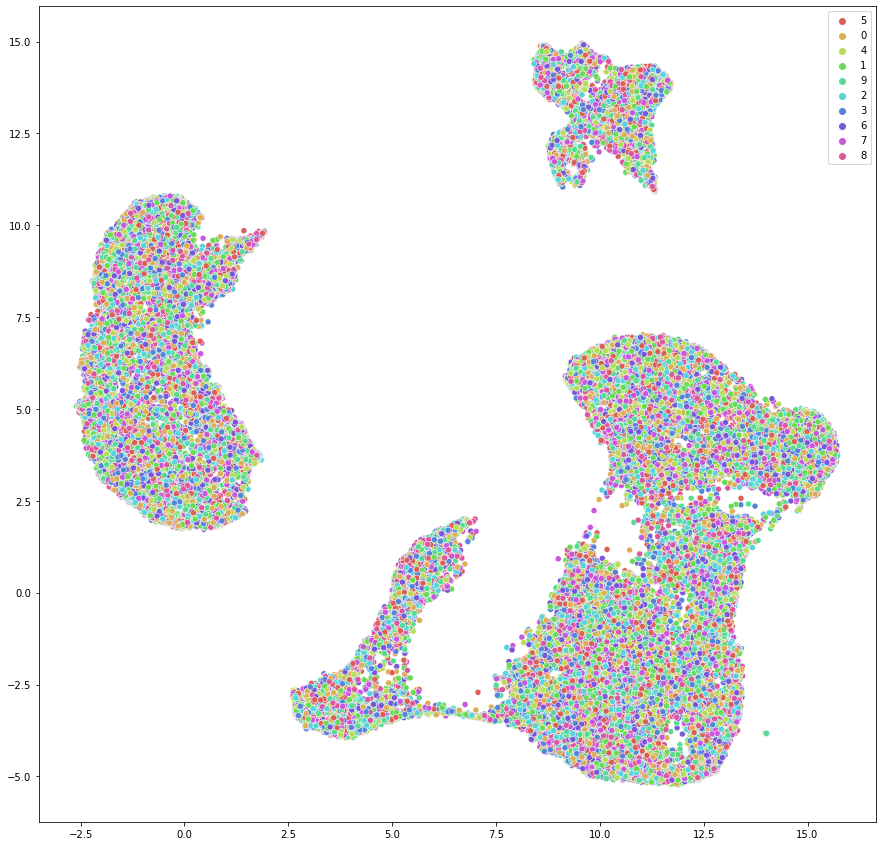

In [367]:
model = umap.UMAP(random_state=42)
umap_fmnist = model.fit_transform(X_fmnist_all)

fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = umap_fmnist[:,0], y = umap_fmnist[:,1], hue =y_mnist_all, 
                palette = sns.hls_palette(10), legend = 'full');

Zbiór FMNIST został pogrupowany na trzy klastry, w których wszystkie etykiety są ze sobą wymieszane.

# LargeVis

In [54]:
df_mnist_largevis_embedding = pd.read_csv(
    'mnist_vis_out.txt',
    sep=' ',
    header=0,
    names=['Component 1', 'Component 2'])

mnist_largevis_embedding = df_mnist_largevis_embedding.values
df_mnist_largevis_embedding.head()

Component 1  Component 2
0    11.968012     6.044398
1    32.303223     2.512996
2   -27.399160   -17.749571
3   -22.922476    14.632609
4   -21.657269    -7.259162

In [57]:
df_fmnist_largevis_embedding = pd.read_csv(
    'fmnist_vis_out.txt',
    sep=' ',
    header=0,
    names=['Component 1', 'Component 2'])

fmnist_largevis_embedding = df_fmnist_largevis_embedding.values
df_fmnist_largevis_embedding.head()

Component 1  Component 2
0    12.631873   -22.384851
1   -17.051981    26.304689
2    -9.255348    14.999328
3    -7.707053    14.042500
4    -3.399491    15.376377

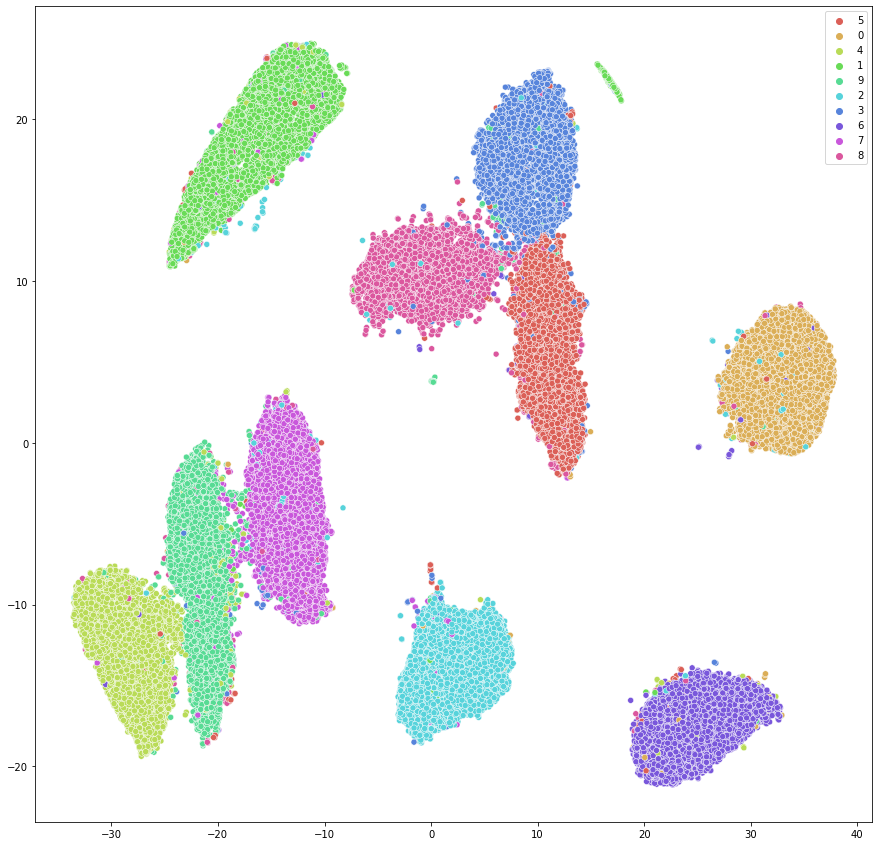

In [96]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = mnist_largevis_embedding[:,0], y = mnist_largevis_embedding[:,1], 
                hue =y_mnist_all, palette = sns.hls_palette(10), legend = 'full');

LargeVis po wizualizacji dla zbioru MNIST jest bardzo zbliżony do metody UMAP tzn. widoczne są poklastrowane etykiety, między którymi zachowana jest odległość, a "podobne" cyfry znajdują się bliżej siebie.

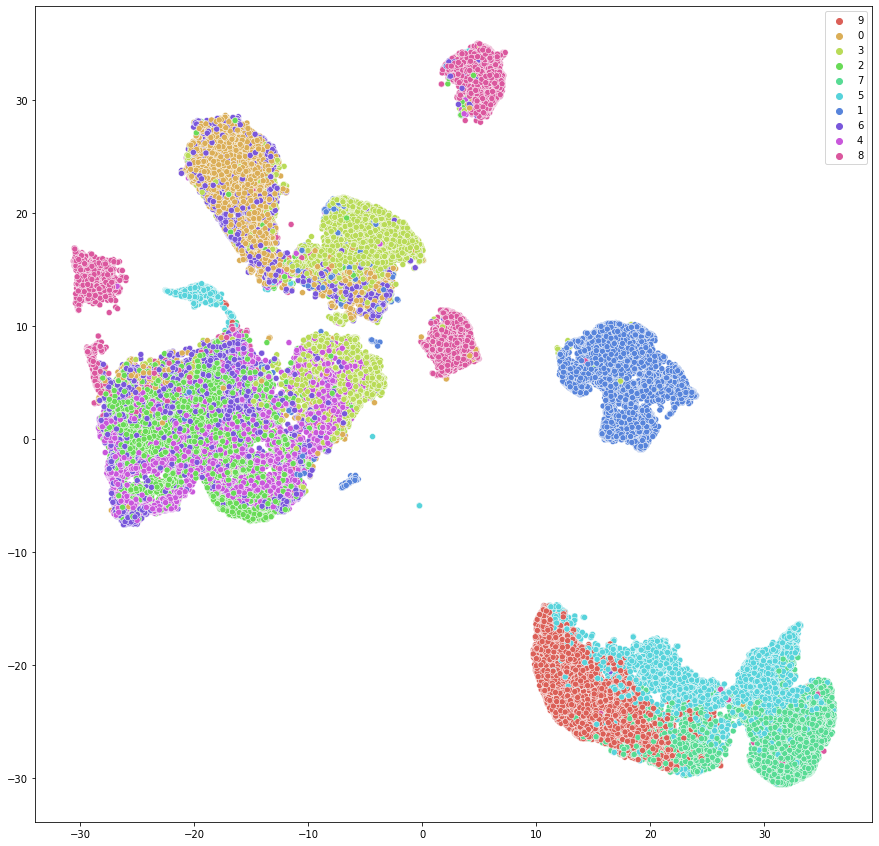

In [97]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.scatterplot(x = fmnist_largevis_embedding[:,0], y = fmnist_largevis_embedding[:,1], 
                hue =y_fmnist_all, palette = sns.hls_palette(10), legend = 'full');

Ciekawą obserwacją jest to, że jedna z etykiet została rozdzielona na trzy odseparowane klastry. Metoda LargeVis podobnie jak pozostałe nie poradziła sobie z wizualizacją zbioreu FMIST

In [2]:
markers = ["x", "o", "s", "*", "^", ".", "X"]
colors = ["red", "blue", "green", "brown", "orange", "cyan", "grey", "purple"]


@numba.jit(nopython=True)
def knngain(d_hd, d_ld, labels):
    # Number of data points
    N = d_hd.shape[0]
    N_1 = N - 1
    k_hd = np.zeros(shape=N_1, dtype=np.int64)
    k_ld = np.zeros(shape=N_1, dtype=np.int64)
    # For each data point
    for i in range(N):
        c_i = labels[i]
        di_hd = d_hd[i, :].argsort(kind="mergesort")
        di_ld = d_ld[i, :].argsort(kind="mergesort")
        # Making sure that i is first in di_hd and di_ld
        for arr in [di_hd, di_ld]:
            for idj, j in enumerate(arr):
                if j == i:
                    idi = idj
                    break
            if idi != 0:
                arr[idi] = arr[0]
            arr = arr[1:]
        for k in range(N_1):
            if c_i == labels[di_hd[k]]:
                k_hd[k] += 1
            if c_i == labels[di_ld[k]]:
                k_ld[k] += 1
    # Computing the KNN gain
    gn = (k_ld.cumsum() - k_hd.cumsum()).astype(np.float64) / (
        (1.0 + np.arange(N_1)) * N
    )
    # Returning the KNN gain and its AUC
    return gn, eval_auc(gn)


@numba.jit(nopython=True)
def eval_auc(arr):
    i_all_k = 1.0 / (np.arange(arr.size) + 1.0)
    return np.float64(arr.dot(i_all_k)) / (i_all_k.sum())


@numba.jit(nopython=True)
def eval_rnx(Q):
    N_1 = Q.shape[0]
    N = N_1 + 1
    # Computing Q_NX
    qnxk = np.empty(shape=N_1, dtype=np.float64)
    acc_q = 0.0
    for K in range(N_1):
        acc_q += Q[K, K] + np.sum(Q[K, :K]) + np.sum(Q[:K, K])
        qnxk[K] = acc_q / ((K + 1) * N)
    # Computing R_NX
    arr_K = np.arange(N_1)[1:].astype(np.float64)
    rnxk = (N_1 * qnxk[: N_1 - 1] - arr_K) / (N_1 - arr_K)
    # Returning
    return rnxk


def eval_dr_quality(d_hd, d_ld):
    # Computing the co-ranking matrix of the embedding, and the R_{NX}(K) curve.
    rnxk = eval_rnx(Q=coranking(d_hd=d_hd, d_ld=d_ld))
    # Computing the AUC, and returning.
    return rnxk, eval_auc(rnxk)


def coranking(d_hd, d_ld):
    # Computing the permutations to sort the rows of the distance matrices in HDS and LDS.
    perm_hd = d_hd.argsort(axis=-1, kind="mergesort")
    perm_ld = d_ld.argsort(axis=-1, kind="mergesort")

    N = d_hd.shape[0]
    i = np.arange(N, dtype=np.int64)
    # Computing the ranks in the LDS
    R = np.empty(shape=(N, N), dtype=np.int64)
    for j in range(N):
        R[perm_ld[j, i], j] = i
    # Computing the co-ranking matrix
    Q = np.zeros(shape=(N, N), dtype=np.int64)
    for j in range(N):
        Q[i, R[perm_hd[j, i], j]] += 1
    # Returning
    return Q[1:, 1:]


def viz_qa(
    Ly,
    ymin=None,
    ymax=None,
    Lmarkers=None,
    Lcols=None,
    Lleg=None,
    Lls=None,
    Lmedw=None,
    Lsdots=None,
    lw=2,
    markevery=0.1,
    tit="",
    folder_name="",
    xlabel="",
    ylabel="",
    alpha_plot=0.9,
    alpha_leg=0.8,
    stit=25,
    sax=20,
    sleg=15,
    zleg=1,
    loc_leg="best",
    ncol_leg=1,
    lMticks=10,
    lmticks=5,
    wMticks=2,
    wmticks=1,
    nyMticks=11,
    mymticks=4,
    grid=True,
    grid_ls="solid",
    grid_col="lightgrey",
    grid_alpha=0.7,
    xlog=True,
):
    # Number of curves
    nc = len(Ly)
    # Checking the parameters
    if ymin is None:
        ymin = np.min(np.asarray([arr.min() for arr in Ly]))
    if ymax is None:
        ymax = np.max(np.asarray([arr.max() for arr in Ly]))
    if Lmarkers is None:
        Lmarkers = ["x"] * nc
    if Lcols is None:
        Lcols = ["blue"] * nc
    if Lleg is None:
        Lleg = [None] * nc
        add_leg = False
    else:
        add_leg = True
    if Lls is None:
        Lls = ["solid"] * nc
    if Lmedw is None:
        Lmedw = [float(lw) / 2.0] * nc
    if Lsdots is None:
        Lsdots = [12] * nc

    # Setting the limits of the y-axis
    y_lim = [ymin, ymax]

    # Defining the ticks on the y-axis
    yMticks = np.linspace(
        start=ymin, stop=ymax, num=nyMticks, endpoint=True, retstep=False
    )
    ymticks = np.linspace(
        start=ymin,
        stop=ymax,
        num=1 + mymticks * (nyMticks - 1),
        endpoint=True,
        retstep=False,
    )
    yMticksLab = [int(round(v * 100.0)) / 100.0 for v in yMticks]

    # Initial values for xmin and xmax
    xmin, xmax = 1, -np.inf

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    if xlog:
        fplot = ax.semilogx
    else:
        fplot = ax.plot

    # Plotting the data
    for id, y in enumerate(Ly):
        x = np.arange(start=1, step=1, stop=y.size + 0.5, dtype=np.int64)
        xmax = max(xmax, x[-1])
        fplot(
            x,
            y,
            label=Lleg[id],
            alpha=alpha_plot,
            color=Lcols[id],
            linestyle=Lls[id],
            lw=lw,
            marker=Lmarkers[id],
            markeredgecolor=Lcols[id],
            markeredgewidth=Lmedw[id],
            markersize=Lsdots[id],
            dash_capstyle="round",
            solid_capstyle="round",
            dash_joinstyle="round",
            solid_joinstyle="round",
            markerfacecolor=Lcols[id],
            markevery=markevery,
        )

    # Setting the limits of the axes
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(y_lim)

    # Setting the major and minor ticks on the y-axis
    ax.set_yticks(yMticks, minor=False)
    ax.set_yticks(ymticks, minor=True)
    ax.set_yticklabels(yMticksLab, minor=False, fontsize=sax)

    # Defining the legend
    if add_leg:
        leg = ax.legend(
            loc=loc_leg,
            fontsize=sleg,
            markerfirst=True,
            fancybox=True,
            framealpha=alpha_leg,
            ncol=ncol_leg,
        )
        if zleg is not None:
            leg.set_zorder(zleg)

    # Setting the size of the ticks labels on the x axis
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(sax)

    # Setting ticks length and width
    ax.tick_params(axis="both", length=lMticks, width=wMticks, which="major")
    ax.tick_params(axis="both", length=lmticks, width=wmticks, which="minor")

    # Setting the positions of the labels
    ax.xaxis.set_tick_params(labelright=False, labelleft=True)
    ax.yaxis.set_tick_params(labelright=False, labelleft=True)

    # Adding the grids
    if grid:
        ax.xaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
        ax.yaxis.grid(
            True, linestyle=grid_ls, which="major", color=grid_col, alpha=grid_alpha
        )
    ax.set_axisbelow(True)

    ax.set_title(tit, fontsize=stit)
    ax.set_xlabel(xlabel, fontsize=sax)
    ax.set_ylabel(ylabel, fontsize=sax)
    # plt.tight_layout()

    # Showing the figure
    fig.savefig(
        "Rysunki\{}.png".format(
            tit
        ),
        dpi=fig.dpi,
    )


class LocalMetric:
    def __init__(self):
        self.L_rnx = []
        self.L_kg = []
        self.Lleg_rnx = []
        self.Lleg_kg = []
        self.Lls = []
        self.number_of_methods = 0

    def calculate_knn_gain_and_dr_quality(
        self,
        X_lds: np.ndarray,
        X_hds: np.ndarray,
        labels: np.ndarray,
        method_name: str,
    ):

        (
            X_hds_train,
            X_hds_test,
            X_lds_train,
            X_lds_test,
            labels_train,
            labels_test,
        ) = train_test_split(X_hds, X_lds, labels, test_size=0.15)

        print("Calculating d_hd")
        d_hd = squareform(X=pdist(X=X_hds_test, metric="euclidean"), force="tomatrix")

        print(method_name)
        d_ld = squareform(X=pdist(X=X_lds_test, metric="euclidean"), force="tomatrix")
        rnxk, auc_rnx = eval_dr_quality(d_hd=d_hd, d_ld=d_ld)
        kg, auc_kg = knngain(d_hd=d_hd, d_ld=d_ld, labels=labels_test)

        self.L_rnx.append(rnxk)
        self.L_kg.append(kg)
        self.Lleg_rnx.append(
            "{} {}".format(int(round(auc_rnx * 1000)) / 1000.0, method_name)
        )
        self.Lleg_kg.append(
            "{} {}".format(int(round(auc_kg * 1000)) / 1000.0, method_name)
        )
        self.Lls.append("solid")
        self.number_of_methods = self.number_of_methods + 1

    def visualize(self):
        Lmarkers = random.sample(markers, self.number_of_methods)
        Lcols = random.sample(colors, self.number_of_methods)
        Lmedw = [1.0] * self.number_of_methods
        Lsdots = [12] * self.number_of_methods

        viz_qa(
            Ly=self.L_rnx,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_rnx,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="DR quality",
            xlabel="Neighborhood size $K$",
            ylabel="$R_{NX}(K)$",
        )

        viz_qa(
            Ly=self.L_kg,
            Lmarkers=Lmarkers,
            Lcols=Lcols,
            Lleg=self.Lleg_kg,
            Lls=self.Lls,
            Lmedw=Lmedw,
            Lsdots=Lsdots,
            tit="KNN gain",
            xlabel="Neighborhood size $K$",
            ylabel="$G_{NN}(K)$",
        )

        print("Finished.")

Calculating d_hd
tsne
Calculating d_hd
umap
Calculating d_hd
largevis
Finished.


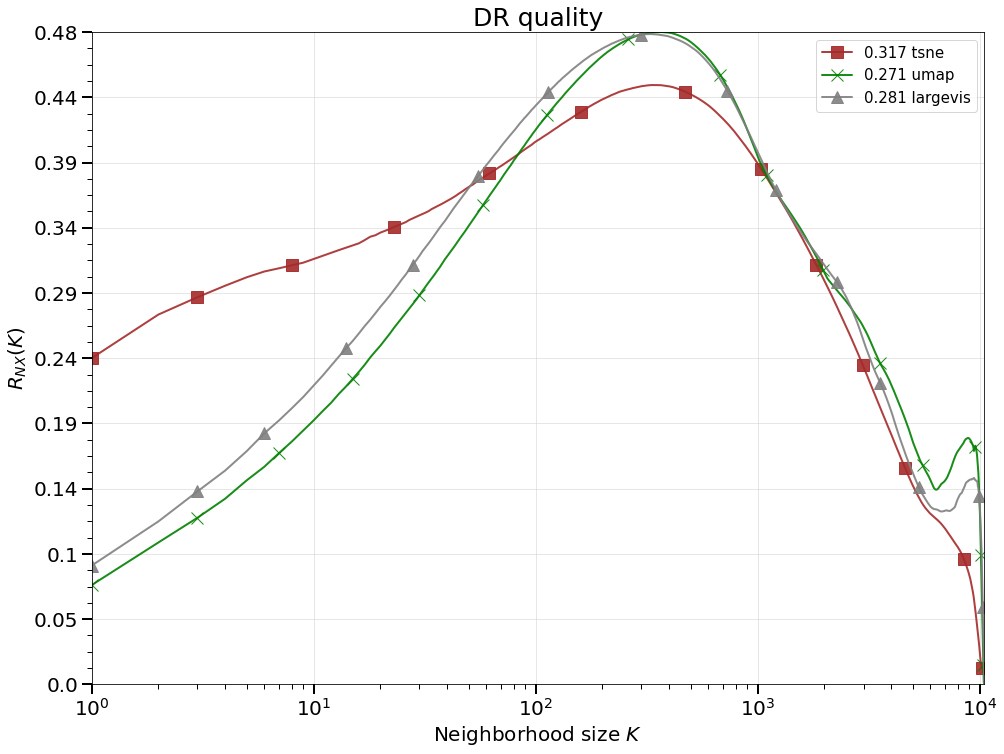

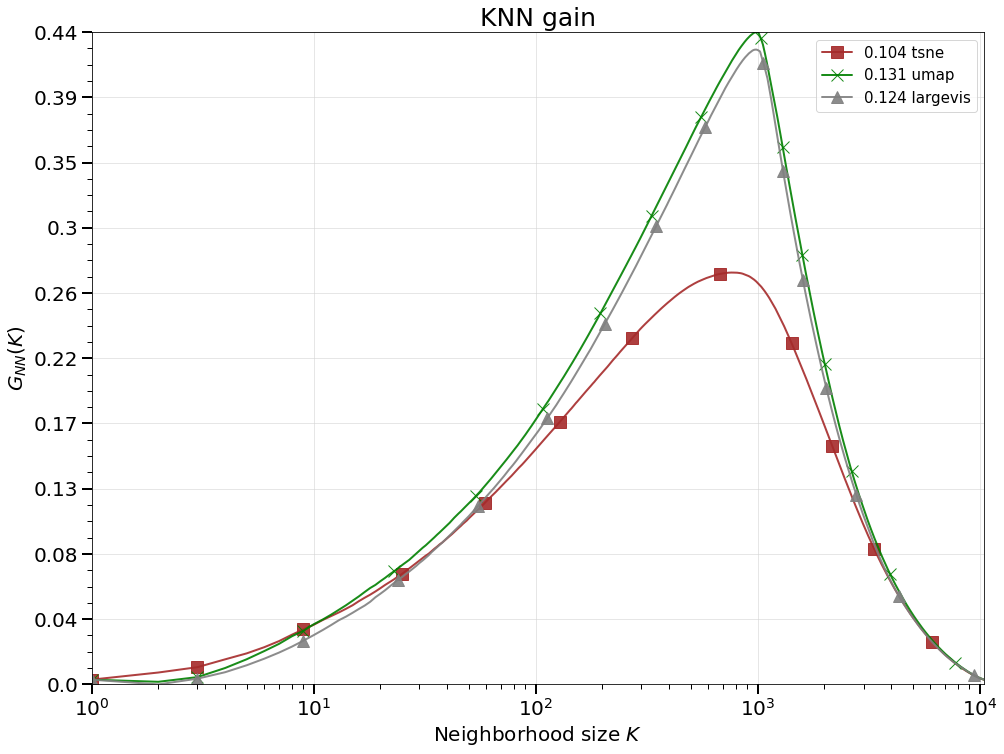

In [100]:
local_metrics = LocalMetric() 

X_embedded = tsne_mnist

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=X_embedded,
    X_hds=X_mnist_all,
    labels=np.array(y_mnist_all.astype(int)),
    method_name="tsne"
)

X_embedded = umap_mnist

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=X_embedded,
    X_hds=X_mnist_all,
    labels=np.array(y_mnist_all.astype(int)),
    method_name="umap"
)

X_embedded = mnist_largevis_embedding
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=X_embedded,
    X_hds=X_mnist_all,
    labels=np.array(y_mnist_all.astype(int)),
    method_name="largevis"
)

local_metrics.visualize()

Z wykresów można wyciągnąć wniosek, że metoda t-SNE, w obu metrykach, radzi sobie lepiej niż pozostałe lokalnie, a globalnie wypada dużo gorzej. W metryce DR Quality wszystkie metody osiągają wmaksymalną wartość współczynnika $R_{NN}$(K) dla K równego około 500, a w metryce KNN gain dla K równego około 1000. Metody UMAP i LargeVis zachowują się bardzo podobnie, co pokrywa się z poprzednio wykonkludowanymi wnioskami.

## In order to compare the results of these three methods, calculate for each case the average distance between two points belonging to the same class divided by the average distance between points belonging to 2 different classes

In [21]:
model = TSNE(n_components = 2, random_state=0)
tsne_mnist = model.fit_transform(X_mnist)
tsne_fmnist = model.fit_transform(X_fmnist)

In [23]:
model = umap.UMAP(random_state=42)
umap_mnist = model.fit_transform(X_mnist)
umap_fmnist = model.fit_transform(X_fmnist)

# MNIST

In [24]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist['target'], test_size=0.98,
                                                    random_state=40, stratify = mnist['target'])

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)


In [25]:
distance_matrix_target

0            1            2            3            4     \
0        0.000000  2518.541244  1261.554993  2238.067247  3243.347807   
1     2518.541244     0.000000  2493.250689  2159.443678  3007.186891   
2     1261.554993  2493.250689     0.000000  2121.619664  3233.159136   
3     2238.067247  2159.443678  2121.619664     0.000000  2864.227994   
4     3243.347807  3007.186891  3233.159136  2864.227994     0.000000   
...           ...          ...          ...          ...          ...   
1395  2612.850359  2979.942449  2636.870494  2810.474337  3152.450793   
1396  2396.045701  2230.526171  2343.687266  1714.723301  2790.207519   
1397  2583.069879  3059.575134  2595.478569  2750.537584  3150.874323   
1398  2472.382656  2788.788984  2367.232773  2399.746028  3436.851321   
1399  2594.782457  2714.816753  2569.465509  2875.101563  3149.859838   

             5            6            7            8            9     ...  \
0     2184.588748  2767.402934  2061.255685  2646.467268  2276.740872  ...   
1     2682.604704  2325.543162  2696.174512  2354.221527  2611.547625  ...   
2     2248.289794  2722.910575  2038.469033  2634.162106  2171.028328  ...   
3     2373.288225  2788.124818  2003.581294  2465.563627  2050.487747  ...   
4     3054.104943  3324.577567  2915.188159  2803.164997  2867.930264  ...   
...           ...          ...          ...          ...          ...  ...   
1395  2130.640045  3209.752950  2632.188443  3002.622187  2822.065556  ...   
1396  2499.450140  2903.444162  2234.678500  2447.278080  2314.975594  ...   
1397  2524.459150  2958.125927  2672.194417  2959.832934  2579.276061  ...   
1398  2311.554023  2829.294082  2771.125584  2866.532226  2548.944291  ...   
1399  2755.806234  2797.533378  2764.012482  2568.593584  2639.079574  ...   

             1391         1392         1393         1394         1395  \
0     3207.666909  1236.597348  1405.471451  1684.502300  2612.850359   
1     3143.751421  2533.053296  2574.900386  2412.969540  2979.942449   
2     3264.413270  1761.082622  1873.668327  2088.573915  2636.870494   
3     3147.428156  2177.274902  2186.120994  2388.130440  2810.474337   
4     3088.782608  3264.628922  3223.412943  3276.442736  3152.450793   
...           ...          ...          ...          ...          ...   
1395  2956.824310  2660.018797  2793.917501  2753.595649     0.000000   
1396  3160.949857  2351.247329  2413.774016  2424.411063  2777.922605   
1397  2858.685187  2561.977556  2672.965020  2762.348638  1887.262303   
1398  3024.781810  2436.829703  2491.222190  2377.656830  2517.973193   
1399  2660.849676  2686.701881  2840.127462  2687.965774  2929.804601   

             1396         1397         1398         1399  1400  
0     2396.045701  2583.069879  2472.382656  2594.782457     1  
1     2230.526171  3059.575134  2788.788984  2714.816753     3  
2     2343.687266  2595.478569  2367.232773  2569.465509     1  
3     1714.723301  2750.537584  2399.746028  2875.101563     5  
4     2790.207519  3150.874323  3436.851321  3149.859838     0  
...           ...          ...          ...          ...   ...  
1395  2777.922605  1887.262303  2517.973193  2929.804601     7  
1396     0.000000  2868.123254  2503.739403  2805.010695     5  
1397  2868.123254     0.000000  2435.584119  2841.523535     7  
1398  2503.739403  2435.584119     0.000000  2791.488134     7  
1399  2805.010695  2841.523535  2791.488134     0.000000     2  

[1400 rows x 1401 columns]

In [26]:
means = []
for i in range(0, len(distance_matrix_target)): 

    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)
    metric = mean_present_class/mean_different_class
    means.append(metric)

In [27]:
mnist_result = np.array(means).mean()

# TSNE MNIST

In [30]:
X_train, X_test, y_train, y_test = train_test_split(tsne_mnist, y_mnist, test_size=0.98, random_state=40, 
                                                    stratify = y_mnist)

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [31]:
distance_matrix_target

0           1           2           3           4           5    \
0      0.000000  114.455132  112.252296   67.210838   37.282963   92.124344   
1    114.455132    0.000000   40.388336   61.182201  141.838058  148.048767   
2    112.252296   40.388336    0.000000   81.580925  130.222610  118.961220   
3     67.210838   61.182201   81.580925    0.000000  102.547310  136.129974   
4     37.282963  141.838058  130.222610  102.547310    0.000000   68.134499   
..          ...         ...         ...         ...         ...         ...   
275   47.573772  142.813599  127.164803  109.071571   14.398939   53.982342   
276   77.238815  122.373909   94.351273  112.617783   63.422169   25.712593   
277   66.979187   84.627678   60.411148   79.604881   73.227631   63.690918   
278   87.440025  152.453339  125.380547  136.108032   60.302364   10.867864   
279   23.160707   91.396118   91.846352   46.298084   56.301910   97.195969   

            6           7           8           9    ...         271  \
0     38.595406   59.927059   52.507641   56.017529  ...  122.429543   
1    137.901260  154.250549   61.972015   60.495377  ...   47.602692   
2    124.627495  136.697800   66.416389   57.680382  ...   11.275139   
3    101.448341  121.852806   29.025755   40.340347  ...   92.714035   
4      7.508996   24.118679   82.428955   81.359528  ...  138.777878   
..          ...         ...         ...         ...  ...         ...   
275    9.178524   12.814267   86.186256   83.055359  ...  134.900238   
276   55.920010   54.411133   83.810921   74.182838  ...   98.860893   
277   66.755638   76.594574   50.775654   39.365284  ...   67.286865   
278   54.019958   40.793674  108.409378  100.460014  ...  129.770157   
279   55.210110   75.884209   29.424543   34.354244  ...  102.482231   

           272         273         274         275         276        277  \
0    24.243246   58.536053   54.904827   47.573772   77.238815  66.979187   
1    90.478668   76.949104  116.329185  142.813599  122.373909  84.627678   
2    88.790459   95.375183   94.970818  127.164803   94.351273  60.411148   
3    48.755367   15.785451   96.365799  109.071571  112.617783  79.604881   
4    54.596436   95.394661   44.126801   14.398939   63.422169  73.227631   
..         ...         ...         ...         ...         ...        ...   
275  60.321262  103.661392   35.210499    0.000000   51.713470  67.877899   
276  72.218422  114.514191   22.400810   51.713470    0.000000  37.987206   
277  50.713814   84.897812   34.569061   67.877899   37.987206   0.000000   
278  90.578186  135.242966   39.783504   45.924473   31.029703  67.843811   
279   5.213511   41.057823   56.907681   63.070808   77.256477  55.775333   

            278        279  280  
0     87.440025  23.160707    9  
1    152.453339  91.396118    6  
2    125.380547  91.846352    0  
3    136.108032  46.298084    3  
4     60.302364  56.301910    7  
..          ...        ...  ...  
275   45.924473  63.070808    7  
276   31.029703  77.256477    1  
277   67.843811  55.775333    2  
278    0.000000  94.982521    3  
279   94.982521   0.000000    8  

[280 rows x 281 columns]

In [32]:
means = []
for i in range(0, len(distance_matrix_target)): 

    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)
    metric = mean_present_class/mean_different_class
    means.append(metric)

In [33]:
tnse_mnist_result = np.array(means).mean()

# UMAP MNIST

In [35]:
X_train, X_test, y_train, y_test = train_test_split(umap_mnist, y_mnist, test_size=0.98, stratify = y_mnist)

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [36]:
distance_matrix_target

0          1          2          3         4         5    \
0     0.000000   8.164833   7.620085   4.572154  4.838881  4.123507   
1     8.164833   0.000000   1.195737   9.253828  3.562410  4.093052   
2     7.620085   1.195737   0.000000   9.303699  3.452320  3.759230   
3     4.572154   9.253828   9.303699   0.000000  5.853281  5.720934   
4     4.838881   3.562410   3.452320   5.853281  0.000000  0.823925   
..         ...        ...        ...        ...       ...       ...   
275   9.939629   9.190830   9.981959   6.307447  7.639592  8.199008   
276   5.118614   9.217532   9.349575   0.639674  5.921756  5.877682   
277  10.840991  10.381877  11.180261   6.923022  8.801995  9.337077   
278   9.113273   4.749761   3.716226  12.057825  6.474305  6.371556   
279  10.644625   3.313751   3.158975  12.431478  6.595954  6.913216   

           6          7          8         9    ...        271        272  \
0     6.172491   4.409855   8.338531  8.997638  ...   9.533914   1.064320   
1    12.311666   9.510424   4.048122  1.408604  ...   7.137575   8.454023   
2    11.324327   9.516068   2.944342  2.604135  ...   8.038751   8.045497   
3    10.471555   0.419561  11.176705  9.427086  ...   6.836873   3.547009   
4     9.968558   6.064146   5.581343  4.184869  ...   6.232654   4.964476   
..         ...        ...        ...       ...  ...        ...        ...   
275  16.109161   6.711466  12.799075  8.413519  ...   2.288896   9.178164   
276  11.080808   1.021333  11.358459  9.295112  ...   6.322325   4.116893   
277  17.010830   7.305202  13.996410  9.578556  ...   3.382309  10.020913   
278  10.678651  12.178564   0.893691  6.031785  ...  11.749793   9.876157   
279  13.546015  12.656737   3.351596  3.950213  ...  10.183414  11.148179   

           273        274        275        276        277        278  \
0     4.634883   7.596456   9.939629   5.118614  10.840991   9.113273   
1    11.189527   3.246279   9.190830   9.217532  10.381877   4.749761   
2    10.272621   2.075406   9.981959   9.349575  11.180261   3.716226   
3     8.936832  10.225121   6.307447   0.639674   6.923022  12.057825   
4     8.620160   4.577129   7.639592   5.921756   8.801995   6.474305   
..         ...        ...        ...        ...        ...        ...   
275  14.574329  11.805169   0.000000   5.692952   1.198673  13.644634   
276   9.542788  10.388705   5.692952   0.000000   6.287704  12.246184   
277  15.468932  13.001542   1.198673   6.287704   0.000000  14.842891   
278  10.080109   1.900053  13.644634  12.246184  14.842891   0.000000   
279  12.712888   3.418638  12.344563  12.445588  13.517932   3.404693   

           279  280  
0    10.644625    5  
1     3.313751    9  
2     3.158975    9  
3    12.431478    3  
4     6.595954    2  
..         ...  ...  
275  12.344563    1  
276  12.445588    3  
277  13.517932    1  
278   3.404693    4  
279   0.000000    4  

[280 rows x 281 columns]

In [37]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [38]:
umap_mnist_result = np.array(means).mean()

# LARGEVIS MNIST

In [58]:
X_train, X_test, y_train, y_test = train_test_split(mnist_largevis_embedding, y_mnist_all, 
                                                    test_size=0.98, stratify = y_mnist_all)

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [59]:
distance_matrix_target

0          1          2          3          4          5     \
0      0.000000  24.993422  48.392804  40.455189  46.578338  61.347326   
1     24.993422   0.000000  30.103693  26.584501  34.214231  59.994317   
2     48.392804  30.103693   0.000000  10.130690  11.864038  42.401268   
3     40.455189  26.584501  10.130690   0.000000   7.637115  36.753369   
4     46.578338  34.214231  11.864038   7.637115   0.000000  30.815066   
...         ...        ...        ...        ...        ...        ...   
1395  13.405028  26.831676  41.326694  31.986161  36.764084  48.095446   
1396  49.625997  31.358891   1.276325  11.000131  11.947782  42.201201   
1397  62.727274  60.782642  42.337456  37.082708  30.894900   1.826036   
1398  66.665971  56.310858  29.614969  29.726375  22.102862  22.640387   
1399  58.700970  59.016437  43.611488  37.084199  31.807543   4.399350   

           6          7          8          9     ...       1391       1392  \
0     20.140045  37.894237  18.607269  54.109963  ...  36.153731  39.027973   
1     18.193970  24.759793  17.024700  55.148780  ...  11.917034  23.135281   
2     29.317093  12.291660  30.368466  41.617056  ...  21.051868   9.577618   
3     20.551819   2.575699  21.900469  34.334495  ...  21.383957   4.078431   
4     26.438552   9.612939  28.009648  29.754281  ...  28.565140  11.422866   
...         ...        ...        ...        ...  ...        ...        ...   
1395  12.357626  29.458878  11.952206  40.741172  ...  35.106834  31.776284   
1396  30.478872  13.261432  31.555138  41.667728  ...  22.183204  10.739538   
1397  45.924790  37.701612  47.763111  10.065560  ...  58.294455  41.145433   
1398  46.901551  31.664394  48.652538  27.795683  ...  49.828046  33.323620   
1399  43.081402  37.280066  44.878600   4.636241  ...  57.745156  41.038913   

           1393       1394       1395       1396       1397       1398  \
0     11.121350  20.271180  13.405028  49.625997  62.727274  66.665971   
1     23.883967  22.568646  26.831676  31.358891  60.782642  56.310858   
2     40.469547  31.723591  41.326694   1.276325  42.337456  29.614969   
3     31.522931  22.277938  31.986161  11.000131  37.082708  29.726375   
4     36.857840  27.201311  36.764084  11.947782  30.894900  22.102862   
...         ...        ...        ...        ...        ...        ...   
1395   3.335395   9.711989   0.000000  42.439353  49.521291  55.121997   
1396  41.627498  32.812252  42.439353   0.000000  42.083183  28.803420   
1397  51.620418  43.501590  49.521291  42.083183   0.000000  21.389601   
1398  56.062939  46.447040  55.121997  28.803420  21.389601   0.000000   
1399  47.685138  40.207852  45.345093  43.535882   6.206170  26.358846   

           1399  1400  
0     58.700970     4  
1     59.016437     1  
2     43.611488     9  
3     37.084199     8  
4     31.807543     5  
...         ...   ...  
1395  45.345093     9  
1396  43.535882     3  
1397   6.206170     6  
1398  26.358846     0  
1399   0.000000     6  

[1400 rows x 1401 columns]

In [60]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [61]:
largevis_mnist_result = np.array(means).mean()

# FMNIST

In [41]:
X_train, X_test, y_train, y_test = train_test_split(fmnist.data, fmnist['target'], test_size=0.98, stratify = fmnist['target'])

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)


In [42]:
distance_matrix_target

0            1            2            3            4     \
0        0.000000  3967.570793  1911.235726  2365.294696  3525.988372   
1     3967.570793     0.000000  3785.059577  3595.471179  3448.533601   
2     1911.235726  3785.059577     0.000000  2987.813080  2678.337544   
3     2365.294696  3595.471179  2987.813080     0.000000  3897.911107   
4     3525.988372  3448.533601  2678.337544  3897.911107     0.000000   
...           ...          ...          ...          ...          ...   
1395  2421.305020  3776.331024  3057.931981  1933.000517  3934.164969   
1396  2106.080008  3427.947928  2531.930686  2187.337194  3120.996475   
1397  1487.529832  3916.099462  1852.628673  2436.624715  3446.160327   
1398  2946.184991  3601.030408  3326.286518  1786.914939  3852.199372   
1399  2697.989807  2735.653304  2954.598958  2531.458078  3366.631105   

             5            6            7            8            9     ...  \
0     1666.749831  3299.322355  1423.145460  2790.699196  2041.671374  ...   
1     3641.149956  3096.573267  3437.211224  3416.032494  3942.441629  ...   
2     2452.093595  3324.029182  1733.728641  2114.634720  1767.782792  ...   
3     2247.103469  2876.061369  2400.797368  3421.443993  2958.209425  ...   
4     3459.041341  3705.370967  2632.762997  2123.596949  2965.704975  ...   
...           ...          ...          ...          ...          ...  ...   
1395  2360.072245  3033.152156  2509.120364  3502.330938  2950.325745  ...   
1396  2081.708433  3076.012191  1875.107997  2751.753078  2471.341134  ...   
1397  1816.898456  3153.430354  1656.609187  2695.212608  1708.412421  ...   
1398  2774.905224  3057.315816  2828.766339  3578.934478  3265.512517  ...   
1399  2313.744584  2964.833722  2238.721510  2930.086859  3072.183751  ...   

             1391         1392         1393         1394         1395  \
0     3399.608213  3514.003273  2852.766727  1069.037417  2421.305020   
1     2884.490596  3156.968007  3711.324023  3915.942160  3776.331024   
2     3267.331327  2939.345675  3322.460233  2263.366740  3057.931981   
3     3159.727995  3918.542586  2051.998294  2173.462215  1933.000517   
4     3273.208212  2574.412749  3976.823858  3709.923315  3934.164969   
...           ...          ...          ...          ...          ...   
1395  3336.698968  3994.973216  1006.915091  2329.556825     0.000000   
1396  2541.512345  3281.051661  2319.467396  2129.986385  2159.196378   
1397  3338.757404  3454.454805  2893.934865  1426.129728  2490.481279   
1398  3208.411445  4004.723336  1388.664826  2874.798602  1611.848008   
1399  1990.557460  3323.190034  2781.347335  2441.643709  2681.796599   

             1396         1397         1398         1399  1400  
0     2106.080008  1487.529832  2946.184991  2697.989807     1  
1     3427.947928  3916.099462  3601.030408  2735.653304     8  
2     2531.930686  1852.628673  3326.286518  2954.598958     1  
3     2187.337194  2436.624715  1786.914939  2531.458078     5  
4     3120.996475  3446.160327  3852.199372  3366.631105     4  
...           ...          ...          ...          ...   ...  
1395  2159.196378  2490.481279  1611.848008  2681.796599     7  
1396     0.000000  2268.342126  2298.412713  2127.866537     8  
1397  2268.342126     0.000000  2951.627517  2708.921926     3  
1398  2298.412713  2951.627517     0.000000  2756.069121     7  
1399  2127.866537  2708.921926  2756.069121     0.000000     8  

[1400 rows x 1401 columns]

In [43]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [44]:
fmnist_result = np.array(means).mean()

# TSNE FMNIST

In [46]:
X_train, X_test, y_train, y_test = train_test_split(tsne_fmnist, y_fmnist, test_size=0.98, stratify = y_fmnist)

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [47]:
distance_matrix_target

0           1           2           3          4           5    \
0     0.000000   56.023941   84.267540   54.658161  68.515877   37.189495   
1    56.023941    0.000000   34.263351  100.881821  77.729721   92.936478   
2    84.267540   34.263351    0.000000  118.355186  77.912254  121.252983   
3    54.658161  100.881821  118.355186    0.000000  58.099422   46.828491   
4    68.515877   77.729721   77.912254   58.099422   0.000000   89.604164   
..         ...         ...         ...         ...        ...         ...   
275  50.951603   94.159012  110.509094    8.365458  50.068996   49.226635   
276  61.024666  112.111023  132.219833   16.508947  74.608154   41.931633   
277  25.398453   78.454613  102.515259   30.839252  64.382332   25.243910   
278  39.454861   26.867371   61.104897   92.337906  86.149536   73.096283   
279  32.795258   85.616699  116.169922   58.968891  94.738106   14.593783   

            6           7           8           9    ...         271  \
0     75.935928   59.785000   67.186386   89.537941  ...   87.953499   
1     70.537430  114.826508  115.622086   97.082100  ...  128.441559   
2     63.402378  144.043747  133.454605   92.000656  ...  139.838074   
3     75.944298   60.407978   15.107109   69.933495  ...   34.245144   
4     19.096977  110.317162   70.803688   21.577312  ...   66.404800   
..          ...         ...         ...         ...  ...         ...   
275   67.699738   65.235657   23.094101   62.939507  ...   37.044872   
276   92.373787   49.515137   10.101313   85.927528  ...   38.617195   
277   77.486893   46.982464   42.094452   82.698853  ...   65.025055   
278   84.648048   93.244293  105.835114  107.371727  ...  123.895386   
279  105.517052   30.017538   65.363396  114.095772  ...   92.366043   

            272        273         274         275         276         277  \
0     94.401093  30.298616   82.474190   50.951603   61.024666   25.398453   
1    124.739571  46.822651   43.300335   94.159012  112.111023   78.454613   
2    129.948257  80.742180   18.934492  110.509094  132.219833  102.515259   
3     48.302040  84.762009  108.141136    8.365458   16.508947   30.839252   
4     52.356361  91.948341   61.898632   50.068996   74.608154   64.382332   
..          ...        ...         ...         ...         ...         ...   
275   46.571053  81.250214   99.957542    0.000000   24.674080   29.356606   
276   58.793987  89.663055  123.089828   24.674080    0.000000   35.626324   
277   75.695908  54.575409   96.765808   29.356606   35.626324    0.000000   
278  125.578888  20.463970   68.156845   87.225990  100.277756   64.718636   
279  106.493454  45.151642  115.241524   59.987270   55.999722   32.119488   

            278         279  280  
0     39.454861   32.795258    3  
1     26.867371   85.616699    4  
2     61.104897  116.169922    2  
3     92.337906   58.968891    7  
4     86.149536   94.738106    8  
..          ...         ...  ...  
275   87.225990   59.987270    5  
276  100.277756   55.999722    7  
277   64.718636   32.119488    3  
278    0.000000   63.272308    0  
279   63.272308    0.000000    1  

[280 rows x 281 columns]

In [48]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [49]:
tnse_fmnist_result = np.array(means).mean()

# UMAP FMNIST

In [50]:
X_train, X_test, y_train, y_test = train_test_split(umap_fmnist, y_fmnist, test_size=0.98, stratify = y_fmnist)

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [51]:
distance_matrix_target

0          1          2          3          4          5    \
0     0.000000   5.969837  16.156099  14.340014  15.943312   1.613141   
1     5.969837   0.000000  13.904848  11.949705  14.221175   7.577439   
2    16.156099  13.904848   0.000000   1.955378   1.413215  16.950254   
3    14.340014  11.949705   1.955378   0.000000   2.590864  15.205349   
4    15.943312  14.221175   1.413215   2.590864   0.000000  16.616119   
..         ...        ...        ...        ...        ...        ...   
275   3.730967   2.630537  13.552339  11.632125  13.606546   5.260122   
276  10.354413   7.886590   6.098913   4.160224   6.334696  11.364573   
277   4.932517   1.089955  13.851137  11.900430  14.059952   6.531052   
278  14.653822  13.117422   2.162772   2.177531   1.307335  15.312103   
279   6.603755   8.408530  10.635220   9.133510  10.071829   6.821665   

           6          7          8          9    ...        271        272  \
0    16.661577   4.443141  11.548536   0.548770  ...   3.982468  11.986874   
1    14.476529   1.960681   8.357455   6.518430  ...   3.078922   6.051984   
2     0.577215  15.323682   5.629720  16.468493  ...  16.335197  14.931999   
3     2.527189  13.375176   3.706402  14.674052  ...  14.393512  13.181077   
4     1.349226  15.505969   6.207040  16.215750  ...  16.467794  15.765843   
..         ...        ...        ...        ...  ...        ...        ...   
275  14.099360   2.260110   8.404553   4.262731  ...   2.944497   8.615572   
276   6.657880   9.229177   1.560056  10.731018  ...  10.236337  10.191286   
277  14.415004   1.487157   8.428795   5.480981  ...   2.582866   7.134126   
278   2.400002  14.334380   5.371546  14.920207  ...  15.273671  15.025029   
279  11.049198   8.426618   7.728538   6.699771  ...   8.882925  13.500422   

           273        274        275        276        277        278  \
0     8.693758   4.390446   3.730967  10.354413   4.932517  14.653822   
1    11.448012   9.869084   2.630537   7.886590   1.089955  13.117422   
2    11.510795  16.483074  13.552339   6.098913  13.851137   2.162772   
3    10.412431  14.942129  11.632125   4.160224  11.900430   2.177531   
4    10.609159  15.901384  13.606546   6.334696  14.059952   1.307335   
..         ...        ...        ...        ...        ...        ...   
275   9.106892   7.283884   0.000000   7.478966   1.558787  12.389724   
276   8.444492  11.584283   7.478966   0.000000   7.762658   5.260491   
277  10.539503   8.779351   1.558787   7.762658   0.000000  12.904239   
278   9.405227  14.603967  12.389724   5.260491  12.904239   0.000000   
279   3.086464   5.848864   6.183662   6.174152   7.543258   8.769365   

           279  280  
0     6.603755    4  
1     8.408530    3  
2    10.635220    7  
3     9.133510    5  
4    10.071829    7  
..         ...  ...  
275   6.183662    3  
276   6.174152    5  
277   7.543258    3  
278   8.769365    8  
279   0.000000    8  

[280 rows x 281 columns]

In [52]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [53]:
umap_fmnist_result = np.array(means).mean()

# LARGEVIS FMNIST

In [62]:
X_train, X_test, y_train, y_test = train_test_split(fmnist_largevis_embedding, fmnist['target'], test_size=0.98, 
                                                    stratify = fmnist['target'])

distance_matrix = euclidean_distances(X_train[:, :], X_train[:, :])
distance_matrix = pd.DataFrame(data = distance_matrix)
distance_matrix_target = pd.concat([distance_matrix, pd.DataFrame(y_train)], ignore_index=True, sort=False, axis=1)

In [63]:
distance_matrix_target

0          1          2          3          4          5     \
0      0.000000  13.399116   8.666620  48.476703   6.480545  13.338798   
1     13.399116   0.000000  18.111958  50.433063   7.606669   0.277547   
2      8.666620  18.111958   0.000000  40.312477  13.645358  18.180476   
3     48.476703  50.433063  40.312477   0.000000  51.072681  50.675628   
4      6.480545   7.606669  13.645358  51.072681   0.000000   7.473123   
...         ...        ...        ...        ...        ...        ...   
1395  50.349446  53.094708  41.991889   3.791178  53.312378  53.329915   
1396  47.186614  50.551995  38.737628   5.306111  50.395667  50.779108   
1397   5.843715  14.360083  14.379741  54.316851   6.888016  14.194329   
1398  22.888569  34.232586  27.317163  65.483714  26.746600  34.059731   
1399  16.799418  22.116739  25.049648  65.244114  16.249248  21.871074   

           6          7          8          9     ...       1391       1392  \
0     10.131702  16.717781  31.734662  10.511949  ...   6.014867  36.030552   
1     20.530973  30.115888  43.011679  21.663159  ...   8.168730  39.865442   
2      2.505617  16.357304  24.900890  16.802510  ...  10.197635  27.603647   
3     40.052171  51.368805  37.499173  56.918177  ...  46.576944  13.196449   
4     15.679403  22.901326  37.914625  14.109050  ...   4.495894  39.320796   
...         ...        ...        ...        ...  ...        ...        ...   
1395  41.522910  52.075980  36.818770  58.374261  ...  48.827366  14.411348   
1396  38.162129  48.430420  33.118373  54.976555  ...  45.930550  11.156603   
1397  15.531161  17.881297  35.872788   7.329006  ...   9.696691  41.862641   
1398  26.490318  14.520317  35.388205  12.684542  ...  28.675272  52.289794   
1399  25.804499  22.766071  43.642122  10.348661  ...  20.168082  52.651392   

           1393       1394       1395       1396       1397       1398  \
0     22.094416   4.323455  50.349446  47.186614   5.843715  22.888569   
1     32.815719  16.887274  53.094708  50.551995  14.360083  34.232586   
2     27.244413  11.091345  41.991889  38.737628  14.379741  27.317163   
3     66.109529  51.403436   3.791178   5.306111  54.316851  65.483714   
4     25.445304   9.377712  53.312378  50.395667   6.888016  26.746600   
...         ...        ...        ...        ...        ...        ...   
1395  67.138085  53.059723   0.000000   3.739441  56.190844  66.378572   
1396  63.569383  49.768067   3.739441   0.000000  53.017346  62.771182   
1397  18.557901   4.614554  56.190844  53.017346   0.000000  19.881988   
1398   2.513672  18.566209  66.378572  62.771182  19.881988   0.000000   
1399  14.268767  14.087369  67.028358  63.787109  11.008390  16.578508   

           1399  1400  
0     16.799418     6  
1     22.116739     6  
2     25.049648     4  
3     65.244114     7  
4     16.249248     2  
...         ...   ...  
1395  67.028358     7  
1396  63.787109     5  
1397  11.008390     6  
1398  16.578508     0  
1399   0.000000     8  

[1400 rows x 1401 columns]

In [64]:
means = []
for i in range(0, len(distance_matrix_target)): 
    
    present_class = distance_matrix_target.iloc[i,-1]
    df_present_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] == present_class].iloc[:,i].reset_index()
    df_present_class = df_present_class.iloc[:,-1]
    mean_present_class = df_present_class.sum()/(len(df_present_class)-1)

    df_diffrent_class = distance_matrix_target[distance_matrix_target.iloc[:,-1] != present_class].iloc[:,i].reset_index()
    df_diffrent_class = df_diffrent_class.iloc[:,-1]
    mean_different_class = df_diffrent_class.sum()/len(df_diffrent_class)

    metric = mean_present_class/mean_different_class
    means.append(metric)

In [65]:
largevis_fmnist_result = np.array(means).mean()

# METRICS

In [67]:
print(f'''Metryka dla MNISTA: {mnist_result:.5f}
Metryka tsne dla MNISTA: {tnse_mnist_result:.5f}
Metryka umap dla MNISTA: {umap_mnist_result:.5f}
Metryka largevis dla MNISTA: {largevis_mnist_result:.5f}
''')

print(f'''Metryka dla FMNISTA: {fmnist_result:.5f}
Metryka tsne dla FMNISTA: {tnse_fmnist_result:.5f}
Metryka umap dla FMNISTA: {umap_fmnist_result:.5f}
Metryka largevis dla FMNISTA: {largevis_fmnist_result:.5f}
''')

Metryka dla MNISTA: 0.86749
Metryka tsne dla MNISTA: 0.36826
Metryka umap dla MNISTA: 0.22013
Metryka largevis dla MNISTA: 0.21015

Metryka dla FMNISTA: 0.75047
Metryka tsne dla FMNISTA: 0.42461
Metryka umap dla FMNISTA: 0.32039
Metryka largevis dla FMNISTA: 0.36077



Można zauważyć, że metryki LargeVis oraz UMAP charakteryzują się większymi odległościami pomiędzy innymi klasami. Dlatego też otrzymane wartości są bliższe zeru. Świadczy to ponownie o globalności obu metod. 